In [2]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np
import gc
%matplotlib inline

# !pip install -q keras 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from coinapi_rest_v1 import CoinAPIv1
from robin_helperfunctions import round_to_hour

In [3]:
# Constants:
window_len = 3
neurons = 1024                 # number of hidden units in the LSTM layer
activation_function = 'tanh'  # activation function for LSTM and Dense layer
loss = 'mse'                  # loss function for calculating the gradient, in this case Mean Squared Error
optimizer= 'adam'             # optimizer for appljying gradient decent
dropout = 0.25                # dropout ratio used after each LSTM layer to avoid overfitting
batch_size = 128              
epochs = 15

In [4]:
### CoinAPI login
from logins import CoinAPI_KEY
coin_api = CoinAPIv1(CoinAPI_KEY)

In [5]:
# symbol = 'KRAKEN_SPOT_ETH_USD'
# agg = '30MIN'
# hours_of_data = 10000
# now = str(pd.Timestamp.today())[0:16]
# time_window = round_to_hour(pd.Timestamp.today() - datetime.timedelta(hours=hours_of_data)).isoformat()
# df = pd.DataFrame(coin_api.ohlcv_historical_data(symbol, {'period_id':agg, 'time_start':time_window, 'limit':'100000'})).set_index('time_period_start')

In [6]:
df = pd.read_csv('eth_historical_data.csv')

In [7]:
model_data = df[['price_open', 'price_high', 'price_low', 'price_close', 'volume_traded', 'trades_count']].reset_index(drop=True)

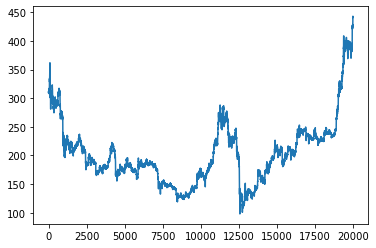

In [8]:
model_data['price_close'].plot()

In [9]:
def split_data(data, training_size=0.8):
  """
  data: Pandas Dataframe
  training_size: proportion of the data to be used for training
  This function splits the data into training_set and test_set based on the given training_size
  Return: train_set and test_set as pandas DataFrame
  """
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]

In [10]:
train_set, test_set = split_data(model_data)

In [11]:
def create_inputs(data, window_len):
    
  '''
  data: pandas DataFrame, this could be either training_set or test_set
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create input array X from the given dataset and will normalize data between 0 and 1
  Return: X, the input for our model as a python list which later needs to be converted to numpy array.
  '''

  inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in data:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs

def to_array(data):
  """
  data: DataFrame
  This function will convert list of inputs to a numpy array
  Return: numpy array
  """
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)


In [12]:
X_train = to_array(create_inputs(train_set, window_len))
X_test = to_array(create_inputs(test_set, window_len))

In [13]:
def create_outputs(data, window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create the labels array for our training and validation and normalize it between 0 and 1
  Return: Normalized numpy array for 'Close' prices of the given coin
  """
  return (data['price_close'][window_len:].values / data['price_close'][:-window_len].values) - 1

In [14]:
train_set['price_close'][:].values

array([311.24, 308.8 , 308.91, ..., 207.62, 206.22, 206.2 ])

In [15]:
train_set['price_close'][window_len:].values

array([310.44, 310.43, 309.55, ..., 207.62, 206.22, 206.2 ])

In [16]:
Y_train = create_outputs(train_set, 3)
Y_test = create_outputs(test_set, 3)

In [17]:
def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  """
  inputs: input data as numpy array
  output_size: number of predictions per input sample
  neurons: number of neurons/ units in the LSTM layer
  active_func: Activation function to be used in LSTM layers and Dense layer
  dropout: dropout ration, default is 0.25
  loss: loss function for calculating the gradient
  optimizer: type of optimizer to backpropagate the gradient
  This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
  and finally a dense layer to produce the output using keras' sequential model.
  Return: Keras sequential model and model summary
  """
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  model.summary()
  return model

In [27]:
Y_train.shape

(15997,)

In [22]:
X_train.shape

(15997, 3, 6)

In [25]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
eth_model = build_model(X_train, output_size=1, neurons=neurons)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 1024)           4222976   
_________________________________________________________________
dropout (Dropout)            (None, 3, 1024)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 1024)           8392704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 1024)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 1024)           8392704   
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 1024)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1024)              8

In [26]:
# train model on data
eth_results = eth_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test), shuffle=False)

Epoch 1/15
  1/125 [..............................] - ETA: 0s - loss: 4.1685e-04 - mae: 0.0131

KeyboardInterrupt: 

In [121]:
def show_plot(data, tag):
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
  ax1.set_ylabel('Closing Price ($)',fontsize=12)
  ax2.set_ylabel('Volume ($ bn)',fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax1.set_xticklabels('')
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
  ax1.plot(data['time_close'],data['price_close'])
  ax2.bar(data['time_close'].values, data['volume_traded'].values)
  fig.tight_layout()
  plt.show()
  

def date_labels(market_data):
  last_date = market_data.iloc[0, 0]
  date_list = [last_date - datetime.timedelta(days=x) for x in range(len(X_test))]
  return[date.strftime('%m/%d/%Y') for date in date_list][::-1]


def plot_results(history, model, Y_target):
  plt.figure(figsize=(25, 20))
  plt.subplot(311)
  plt.plot(history.epoch, history.history['loss'], )
  plt.plot(history.epoch, history.history['val_loss'])
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.title(' Model Loss')
  plt.legend(['Training', 'Test'])

  plt.subplot(312)
  plt.plot(Y_target)
  plt.plot(model.predict(X_train))
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(' Single Point Price Prediction on Training Set')
  plt.legend(['Actual','Predicted'])

  ax1 = plt.subplot(313)
  plt.plot(test_set['price_close'][window_len:].values.tolist())
  plt.plot(((np.transpose(model.predict(X_test)) + 1) * test_set['price_close'].values[:-window_len])[0])
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(' Single Point Price Prediction on Test Set')
  plt.legend(['Actual','Predicted'])
  
#   date_list = date_labels(history)
#   ax1.set_xticks([x for x in range(len(date_list))])
#   for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
#     label.set_visible(False)

  plt.show()

In [129]:
test_set['price_close'].values[:-window_len]

array([206.5 , 206.77, 207.54, ..., 441.53, 440.56, 440.93])

In [144]:
((np.transpose(eth_model.predict(X_test)) + 1) * test_set['price_close'].values[:-window_len])[0]

array([207.63886786, 206.32315233, 206.15080992, ..., 440.75882595,
       443.14676317, 443.4483436 ])

In [146]:
(np.transpose(eth_model.predict(X_test)) + 1)[0][-1]

1.0057114

In [150]:
test_set['price_close']

16000    206.50
16001    206.77
16002    207.54
16003    206.09
16004    206.40
          ...  
19996    440.56
19997    440.93
19998    442.00
19999    442.97
20000    441.00
Name: price_close, Length: 4001, dtype: float64

In [149]:
len(X_test)

3998

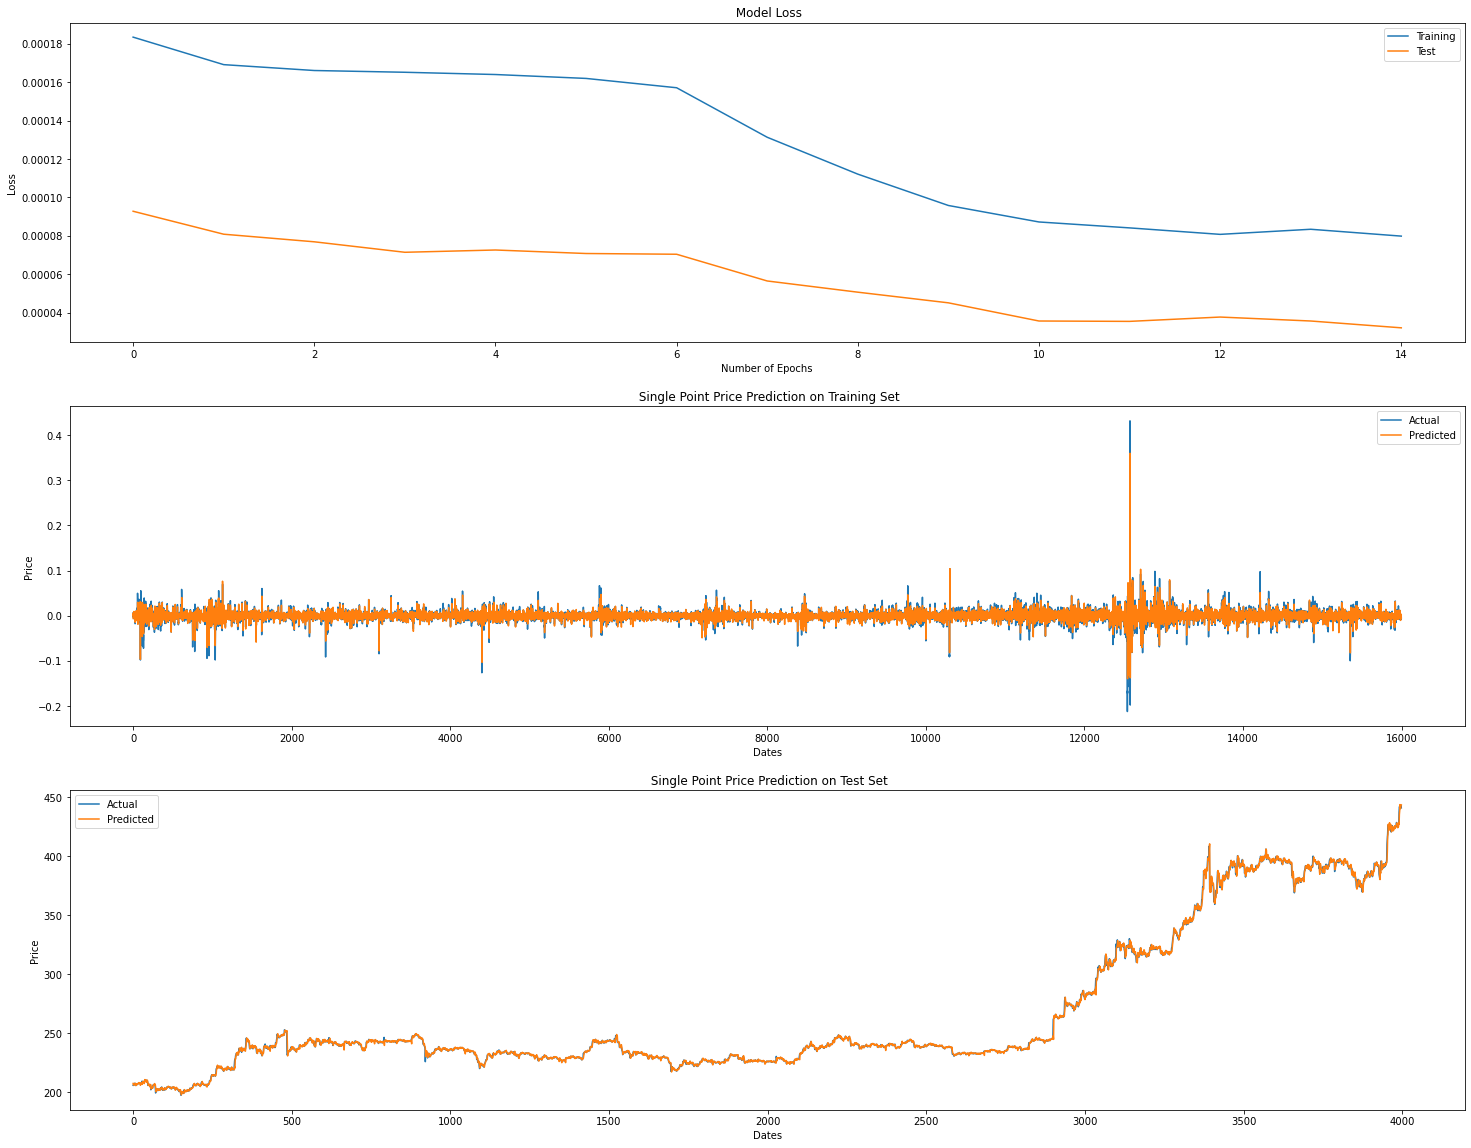

In [122]:
plot_results(eth_results, eth_model, Y_train)

### Single Point Tests

In [88]:
df.tail()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
19996,2020-08-14T17:00:00.0000000Z,2020-08-14T17:30:00.0000000Z,2020-08-14T17:00:01.7180000Z,2020-08-14T17:29:55.2850000Z,441.54,442.60,437.03,440.56,3507.431196,836
19997,2020-08-14T17:30:00.0000000Z,2020-08-14T18:00:00.0000000Z,2020-08-14T17:30:01.9370000Z,2020-08-14T17:59:32.2080000Z,440.31,442.41,438.69,440.93,1392.748513,393
19998,2020-08-14T18:00:00.0000000Z,2020-08-14T18:30:00.0000000Z,2020-08-14T18:00:17.9710000Z,2020-08-14T18:29:32.0840000Z,440.55,444.13,440.28,442.00,1784.620684,453
19999,2020-08-14T18:30:00.0000000Z,2020-08-14T19:00:00.0000000Z,2020-08-14T18:30:01.6520000Z,2020-08-14T18:59:47.9260000Z,442.20,444.50,441.61,442.97,888.232354,268
20000,2020-08-14T19:00:00.0000000Z,2020-08-14T19:30:00.0000000Z,2020-08-14T19:00:04.5300000Z,2020-08-14T19:11:21.2950000Z,442.86,442.91,441.00,441.00,617.408476,147


In [134]:
data = df[['price_open', 'price_high', 'price_low', 'price_close', 'volume_traded', 'trades_count']].reset_index(drop=True).iloc[-4:-1]

In [135]:
data

,price_open,price_high,price_low,price_close,volume_traded,trades_count
19997,440.31,442.41,438.69,440.93,1392.748513,393
19998,440.55,444.13,440.28,442.00,1784.620684,453
19999,442.20,444.50,441.61,442.97,888.232354,268


In [136]:
data_normalized = data.copy()
for col in data:
  data_normalized.loc[:, col] = data_normalized.loc[:, col] / data_normalized.loc[:, col].iloc[0] - 1 
model_input = np.array(np.array(data_normalized))

In [164]:
data_normalized

,price_open,price_high,price_low,price_close,volume_traded,trades_count
19997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19998,0.000545,0.003888,0.003624,0.002427,0.281366,0.152672
19999,0.004292,0.004724,0.006656,0.004627,-0.362245,-0.318066


In [162]:
data['price_close'].iloc[-3]

440.93

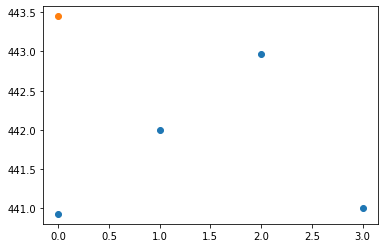

In [161]:
plt.plot(df['price_close'].tail(4).values.tolist(), marker='o', linestyle='')
plt.plot((eth_model.predict(model_reshaped)[0][0] + 1) * data['price_close'].iloc[-3], marker='o', linestyle='')

In [169]:
eth_model.predict(model_reshaped)[0][0]

0.005711388

In [167]:
print(eth_model.predict(model_reshaped)[0][0] + 1) 
print(data['price_close'].iloc[-3])
(eth_model.predict(model_reshaped)[0][0] + 1) * data['price_close'].iloc[-3]

1.0057113878428936
440.93


443.4483222415671